## Support Vector Machine Analysis of Minneapolis Police Activity

Can demographic factors such as gender or race influence how likely it is for a person to receive a citation with contacted by police? Does the location of the stop impact how a person is treated by officers? Many studies and personal anecdotes say that these factors do indeed play a role. The city of Minneapolis, MN has published data regarding their own police activity that offers the opportunity to further study police interaction with the public.

This report will use the data to create a binary classification Support Vector Machine (SVM) that will attempt to use demographic information to predict whether a person will receive a citation when contacted by police.


### Import the basic data and visualization packages

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read in the Data and Prepare it for Modeling

In [3]:
# dataset is available at http://opendata.minneapolismn.gov/datasets/police-stop-data
stops = pd.read_csv("MplsStops.csv")

# the original dataset includes NA values in the 'citationIssued' column
# these entres are counter-productive to our citation prediction efforts and are removed
stops = stops.dropna()

In [4]:
# a look at the complete dataset (NAs removed)
stops.head(2)

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood
28572,36569,17-251489,2017-07-06 11:00:32,suspicious,MDC,NO,NO,NO,Unknown,Unknown,Unknown,44.97128,-93.285779,1,Loring Park
28576,36573,17-251517,2017-07-06 11:19:35,traffic,MDC,NO,NO,NO,Unknown,Black,Female,44.98826,-93.289389,4,Near - North


A graphical look at the data can help decide which variables to use in the model. Two of the plots used during our decision making process are shown below:

Text(0.5,1,'Race of Persons Contacted')

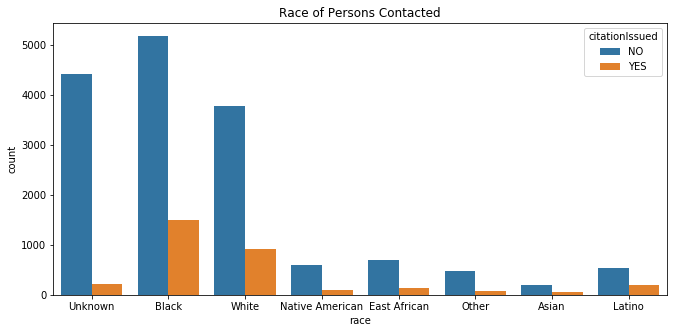

In [5]:
plt.figure(figsize=(11,5))
sns.countplot(x='race', data=stops, hue='citationIssued').set_title('Race of Persons Contacted')

Text(0.5,1,'Gender of Persons Contacted')

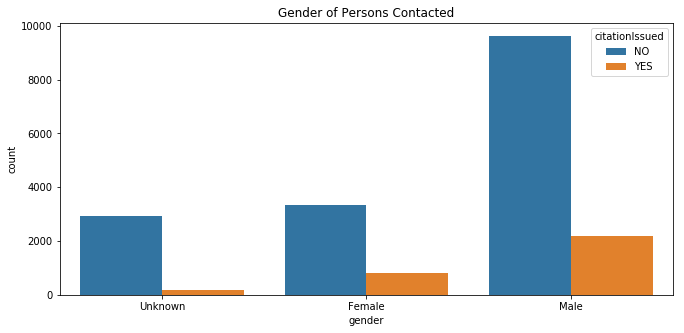

In [6]:
plt.figure(figsize=(11,5))
sns.countplot(x='gender', data=stops, hue='citationIssued').set_title('Gender of Persons Contacted')

Given the wider citation / no citation gap for people whose race or gender is "unknown," those "unknown" race/gender persons will be dropped so they do not unfairly prejudice the resulting model.

In [7]:
stops = stops[stops['race'] != 'Unknown']

In [8]:
stops = stops[stops['gender'] != 'Unknown']

In [9]:
# our prediction will focus on the date/time/location of the stop, nature of the stop, and race of contacted person
# all other columns are removed for ease of visualization
stops = stops[['date', 'problem', 'race', 'gender', 'neighborhood', 'citationIssued']]
stops.head(2)

,date,problem,race,gender,neighborhood,citationIssued
28576,2017-07-06 11:19:35,traffic,Black,Female,Near - North,NO
28588,2017-07-06 12:11:32,suspicious,White,Male,Lyndale,NO


In [10]:
# date and time are combined by the data into one string
#the string is split here and day and time put into individual columns
stops['day'], stops['time'] = stops['date'].str.split(' ', 1).str
stops.head(2)

,date,problem,race,gender,neighborhood,citationIssued,day,time
28576,2017-07-06 11:19:35,traffic,Black,Female,Near - North,NO,2017-07-06,11:19:35
28588,2017-07-06 12:11:32,suspicious,White,Male,Lyndale,NO,2017-07-06,12:11:32


In [11]:
# the days and times are then converted into numeric values; the SVM can't use strings to build the model
stops['day'] = stops['day'].apply(lambda char: char.replace("-", ""))
pd.to_numeric(stops['day'])

stops['time'] = stops['time'].apply(lambda char: char.replace(":", ""))
pd.to_numeric(stops['time'])

stops.head(2)

,date,problem,race,gender,neighborhood,citationIssued,day,time
28576,2017-07-06 11:19:35,traffic,Black,Female,Near - North,NO,20170706,111935
28588,2017-07-06 12:11:32,suspicious,White,Male,Lyndale,NO,20170706,121132


The remanining categorical data must also be converted tonumerical format in order to train a sklearn SVM. This is easily done using the pandas built-in 'factorize'.

In [12]:
# assigning an integer value to each piece of data according to its category
stops.problem, mapping_index = pd.Series(stops.problem).factorize()
stops.race, mapping_index = pd.Series(stops.race).factorize()
stops.gender, mapping_index = pd.Series(stops.gender).factorize()
stops.neighborhood, mapping_index = pd.Series(stops.neighborhood).factorize()
stops.citationIssued, mapping_index = pd.Series(stops.citationIssued).factorize()

stops.head(2)

,date,problem,race,gender,neighborhood,citationIssued,day,time
28576,2017-07-06 11:19:35,0,0,0,0,0,20170706,111935
28588,2017-07-06 12:11:32,1,1,1,1,0,20170706,121132


In [13]:
# rearranging the df columns to make the model building a litter easier
stops = stops[['day', 'time', 'problem', 'race', 'gender', 'neighborhood', 'citationIssued']]
stops.head(2)

,day,time,problem,race,gender,neighborhood,citationIssued
28576,20170706,111935,0,0,0,0,0
28588,20170706,121132,1,1,1,1,0


## Train Test Split

The data ready for modeling so it is split into a training set and a testing set.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = stops.drop('citationIssued',axis=1)
y = stops['citationIssued']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Train the Model

Using the SVC() model from sklearn, the model is fit to the training data.

In [16]:
from sklearn.svm import SVC

In [17]:
stops_model = SVC()

In [18]:
stops_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Evaluate the Model
The above model is used to make predictions and create a confusion matrix and classification report.

In [19]:
predictions = stops_model.predict(X_test)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
print(confusion_matrix(y_test,predictions))

[[3389    0]
 [ 904    0]]


In [22]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88      3389
          1       0.00      0.00      0.00       904

avg / total       0.62      0.79      0.70      4293



C:\Users\JoCho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The dataset is weighted heavily in favor of instances where a citation was not issued. We see from the above table that this initial model took the easy way out and predicted that *none* of the people contacted would receive tickets. Although that simplistic approach got a correct result 84% of the time, it's not very enlightening.

## Using Gridsearch to Improve Model Performance
The GridSearch function provides one way to test a variety of potential parameters, and (hopefully) optimize the predictive capabilities of the model.

In [23]:
from sklearn.model_selection import GridSearchCV

NOTE: To find the most accurate model possible the following GridSearch was run several times before we settled on the parameters you see immediately below. Those initial tests are excluded here.

In [24]:
param_grid = {'C': [0.075 ,0.1, 0.125, 0.2], 'gamma': [2.5, 2, 1, 0.5]} 

In [25]:
grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.075, 0.1, 0.125, 0.2], 'gamma': [2.5, 2, 1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

You can inspect the best parameters found by GridSearchCV in the best_params_ attribute, and the best estimator in the best\_estimator_ attribute:

In [26]:
grid.best_params_

{'C': 0.075, 'gamma': 2.5}

In [27]:
grid.best_estimator_

SVC(C=0.075, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Then re-run predictions can be re-run on this new grid object just like with the original model.

In [28]:
grid_predictions = grid.predict(X_test)

In [29]:
print(confusion_matrix(y_test,grid_predictions))

[[3389    0]
 [ 904    0]]


In [30]:
print(classification_report(y_test,grid_predictions))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88      3389
          1       0.00      0.00      0.00       904

avg / total       0.62      0.79      0.70      4293



C:\Users\JoCho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion
Even after an extensive parameter selection process, the model still cannot identify specific groups of people who will or will not be cited by police. This model may be a failure, but the result is a good one. The above analysis provides evidence that Minneapolis police are unlikely to be making decisions about issuing citations based merely on race, gender. Of course, this basic analysis still leaves open valid questions requiring further study. Consider the following plots:

Text(0.5,1,'Race of Persons Searched by Police')

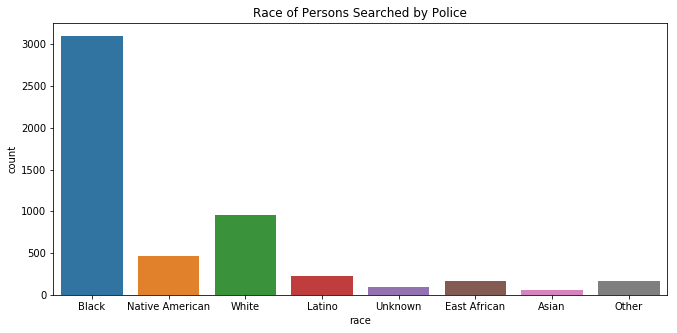

In [31]:
plt.figure(figsize=(11,5))
stops2 = pd.read_csv("MplsStops.csv")
stops2 = stops2[stops2['personSearch'] == 'YES']
sns.countplot(x='race', data=stops2).set_title('Race of Persons Searched by Police')

Text(0.5,1,'Race of Persons with Vehicle Searched by Police')

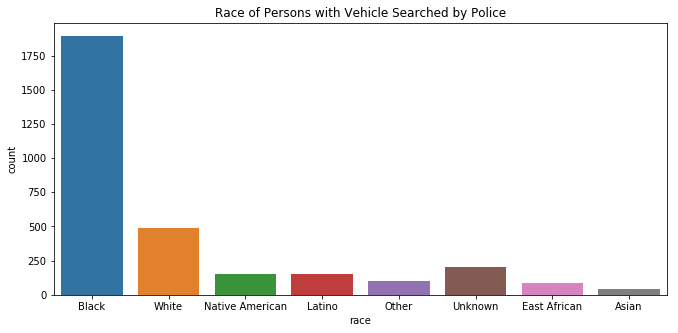

In [32]:
plt.figure(figsize=(11,5))
stops3 = pd.read_csv("MplsStops.csv")
stops3 = stops3[stops3['vehicleSearch'] == 'YES']
sns.countplot(x='race', data=stops3).set_title('Race of Persons with Vehicle Searched by Police')

As is the case in cities across the U.S., African Americans are much more likely to be contacted - and more extensively contacted- by police than any other race. As of the 2010 census, African American's made up only 18.6% of Mineapolis' population (63.8% identified as White). Yet they have the most police interaction by a wide margin. Thus, while the decision to issue citations appears race-neutral, it appears Minneapolis provides another example of why nationwide scrutiny of police behavior continues.